In [ ]:
"""
parameters:
    csv_data:
        mesa, shhs: 'ahi_a0h3'
        mros: 'poahi3'
    segment_2d = False
    segment_len = None
    signal_len = 8*3600*1
    batch_size = 64
    epochs = 500
    optimizer = Adam(lr=5e-4)
    scheduler = None
"""

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from torchinfo import summary
from IPython.display import display
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = Path(r'..\dataset\del_wake')
data_json = Path(r'..\dataset\data_list')
mesa_mros_shhs = 'mesa_mros_shhs_20230215.json'
test_dataset1 = 'apnea-ecg-database_20230819.json'
test_dataset2 = '耕莘dataset_20230313.json'
train_name_lst = ['mesa', 'MrOS_visit1', 'MrOS_visit2']

In [3]:
# MESA + MrOS + SHHS
with open(data_json/mesa_mros_shhs) as f:
    all_npz = json.load(f)
# Apnea-ECG-Database
with open(data_json/test_dataset1) as f:
    all_npz[f'apnea_ecg'] = json.load(f)
# 耕莘dataset
with open(data_json/test_dataset2, encoding='utf-8') as f:
    all_npz['耕莘dataset'] = json.load(f)
    
data_num = [[len(i) for i in v.values()] for v in all_npz.values()]
df = pd.DataFrame(data_num).transpose()
df.index = ['normal', 'mild', 'moderate', 'severe']
df.columns = all_npz.keys()
df.loc['total'] = df.sum(axis=0)
df.loc[:, 'total'] = df.sum(axis=1)
df

,mesa,MrOS_visit1,MrOS_visit2,shhs1,shhs2,apnea_ecg,耕莘dataset,total
normal,414,502,154,1766,629,4,45,3514
mild,643,1029,360,2031,960,0,77,5100
moderate,518,792,283,1237,637,0,61,3528
severe,481,583,229,759,425,4,162,2643
total,2056,2906,1026,5793,2651,8,345,14785


In [4]:
train_list = []
test_list = {k: [] for k in all_npz.keys() if k not in train_name_lst}

for k, v in all_npz.items():
    if k in train_name_lst:
        for i in v.values():
            train_list += i
    else:
        for j in v.values():
            test_list[k] += j

print(f'train list: \n\t{len(train_list)}')
print('test list:')
for k, v in test_list.items():
    print(f'\t{k}: {len(v)}')

train list: 
	5988
test list:
	shhs1: 5793
	shhs2: 2651
	apnea_ecg: 8
	耕莘dataset: 345


In [5]:
SR = 1 # sample rate
segment_2d = False # segment signal to 2D
segment_len = 60*SR if segment_2d else None # length of each segment
signal_len = (8*3600*SR)//segment_len if segment_2d else 8*3600*SR # length of signal

def normalize(signal):
    return signal/100.

def AHI_class(AHI, classes=4, cutoff=15):
    if classes == 2:
        if AHI < cutoff:
            label = 0
        else:
            label = 1
    elif classes == 4:
        if AHI < 5:
            label = 0
        elif 5 <= AHI < 15:
            label = 1
        elif 15 <= AHI < 30:
            label = 2
        else: label = 3
    
    return label

def read_npz_file(file):
    npz_data = np.load(file, allow_pickle=True)
    signal = normalize(npz_data['SpO2'])
    
    if segment_2d:
        segment_num = len(signal)//segment_len
        signal = signal[:segment_num*segment_len].reshape((segment_num, segment_len))
        
    if 'mros' in file:
        label = AHI_class(float(npz_data['csv_data'].item()['poahi3']))
    elif 'apnea' in file or '耕莘' in file:
        label = AHI_class(npz_data['AHI'])
    else:
        label = AHI_class(float(npz_data['csv_data'].item()['ahi_a0h3']))
        
    return signal, label

def cut_pad_signal(signal, length=signal_len, mode='middle'):
    if len(signal) > length:
        cut_len = len(signal)-length
        if mode == 'middle': # cut from middle
            mid = cut_len//2
            return signal[mid:mid+length]
        elif mode == 'random': # random cut
            rand = np.random.randint(cut_len)
            return signal[rand:rand+length]
    
    else:
        pad_len = length-len(signal)
        if segment_2d:
            signal = np.pad(signal, ((0, pad_len), (0, 0)))
        else:
            signal = np.pad(signal, (0, pad_len))
        return signal

In [6]:
train_info = {i: [] for i in ['signal', 'label']}
test_info = {j: {i: [] for i in ['signal', 'label']} for j in test_list.keys()}

for file in tqdm(train_list):
    path = str(data_dir/file)
    signal, label = read_npz_file(path)
    train_info['signal'].append(signal)
    train_info['label'].append(label)

for k, v in test_list.items():
    for file in tqdm(v):
        path = str(data_dir/file)
        signal, label = read_npz_file(path)
        test_info[k]['signal'].append(signal)
        test_info[k]['label'].append(label)

100%|███████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 380.97it/s]


In [9]:
# set model name
time_stamp = datetime.now().strftime('_%Y%m%d_%H%M%S')
model_name = 'm009'+time_stamp

In [6]:
# for reload model
model_name = 'm009_20230220_150313'

In [7]:
from models import m009
model = m009().cuda()
print(model_name)

logs_tb_dir = Path('logs_tb', model_name)
logs_tb_dir.mkdir(parents=True, exist_ok=True)
logs_json_dir = Path('logs_json', model_name)
logs_json_dir.mkdir(parents=True, exist_ok=True)
weights_dir = Path('weights', model_name)
weights_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path('results', model_name)
results_dir.mkdir(parents=True, exist_ok=True)

m009_20230220_150313


In [12]:
class TrainingDataset(Dataset):
    def __init__(self, data_type, signal, label):
        self.data_type = data_type
        self.signal = signal
        self.label = label
        
    def __getitem__(self, index):
        if self.data_type == 'train':
            signal = cut_pad_signal(self.signal[index], mode='random') # fixed length, random cut
        elif self.data_type == 'test':
            signal = cut_pad_signal(self.signal[index]) # fixed length
            
        signal = torch.tensor(signal, dtype=torch.float32).cuda().unsqueeze(0) # [channel, row]
        label = torch.tensor(self.label[index], dtype=torch.int64).cuda()
        return signal, label
    
    def __len__(self):
        return len(self.signal)

In [8]:
batch_size = 64
train_data = DataLoader(TrainingDataset('train', train_info['signal'], train_info['label']),
                        batch_size=batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(TrainingDataset('test', test_info['shhs1']['signal'], test_info['shhs1']['label']),
                       batch_size=batch_size)

In [11]:
# show model summary
model_input, _ = train_data.dataset[0]
summary(model, model_input.unsqueeze(0).size())

Layer (type:depth-idx)                                            Output Shape              Param #
Model                                                             [1, 4]                    --
├─Sequential: 1-1                                                 [1, 16, 1199]             --
│    └─Sequential: 2-1                                            [1, 16, 4799]             --
│    │    └─Conv1d: 3-1                                           [1, 16, 4799]             192
│    │    └─ReLU: 3-2                                             [1, 16, 4799]             --
│    └─Sequential: 2-2                                            [1, 16, 2399]             --
│    │    └─Conv1d: 3-3                                           [1, 16, 2399]             784
│    │    └─ReLU: 3-4                                             [1, 16, 2399]             --
│    └─Sequential: 2-3                                            [1, 16, 1199]             --
│    │    └─Conv1d: 3-5                    

In [13]:
def startTraining(epochs, optimizer, scheduler=None, st_epoch=1, save_step=100, best_loss=10., best_acc=0.):
    logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []} # for json logs
    writer = SummaryWriter(logs_tb_dir, filename_suffix='-training_logs.tb') # for tb logs
    fn_epoch = st_epoch+epochs-1 # final epoch
    len_fn_epoch = len(str(fn_epoch)) # length of final epoch text
    pbar_colors = {'train': 'yellow', 'test': 'green'} # colors of progress bar
    criterion = nn.CrossEntropyLoss() # for CE loss calculation
    
    for e in range(epochs):
        cr_epoch = st_epoch+e # current epoch
        for p, phase in enumerate(['train', 'test']):
            data_num, running_loss, running_acc = 0, 0., 0.
            
            if p == 0:
                model.train() # training mode
                batch_data = train_data
            elif p == 1:
                model.eval() # evaluation mode
                batch_data = test_data

            pbar = tqdm(batch_data, unit='batch', # custom progress bar
                        desc=f'{cr_epoch:0>{len_fn_epoch}}/{fn_epoch} - {phase:>5}: ', colour=pbar_colors[phase])
            
            for b, batch in enumerate(pbar):
                signals, labels = batch
                data_num += signals.size(0)
                
                if p == 0:
                    optimizer.zero_grad() # clear gradients of optimizer
                    outputs = model(signals) # forward
                    loss = criterion(outputs, labels) # calculate loss
                    _, preds = torch.max(outputs.data, 1) # get predicted results
                    loss.backward() # calculate gradients
                    optimizer.step() # update weights
                    
                elif p == 1:
                    with torch.no_grad(): # don't calculate gradients in test
                        outputs = model(signals)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                
                running_loss += loss.item()*signals.size(0)
                running_acc += torch.sum(preds == labels).item()
                
                if b == len(pbar)-1:
                    current_loss = running_loss/data_num # calculate current loss
                    current_acc = running_acc/data_num # calculate current accuracy
                    pbar.set_postfix_str(f'loss: {current_loss:.4f}, acc: {current_acc:.4f}')
            
            if p == 0:
                record_phase = 'Training'

                weights = model.state_dict()
                torch.save(weights, weights_dir/'last.pth') # save last weights
                if cr_epoch%save_step == 0: # save weights when reached step
                    torch.save(weights, weights_dir/f'epoch_{cr_epoch}.pth')
                    
            elif p == 1:
                record_phase = 'Testing'

                if current_loss < best_loss:
                    best_loss = current_loss
                    torch.save(weights, weights_dir/'best_loss.pth') # save lowest loss weights
                if current_acc > best_acc:
                    best_acc = current_acc
                    torch.save(weights, weights_dir/'best_acc.pth') # save highest accuracy weights
            
            # save training logs
            writer.add_scalar(f'Loss/{record_phase}', current_loss, cr_epoch)
            writer.add_scalar(f'Accuracy/{record_phase}', current_acc, cr_epoch)    
            logs[f'{phase}_loss'].append(current_loss)
            logs[f'{phase}_acc'].append(current_acc)
            with open(logs_json_dir/f'epoch_{st_epoch}-{fn_epoch}.json', 'w') as f:
                json.dump(logs, f)
 
        if scheduler:
            scheduler.step() # update scheduler
    
    writer.close()
    print(f"{' Training finished. ':=^80}")
    print(f"{f' best loss: {best_loss:.4f}, best acc: {best_acc:.4f} ':-^80}")
    
    return logs

In [14]:
# training from begining
epochs = 500
optimizer = optim.Adam(model.parameters(), 5e-4)

logs = startTraining(epochs, optimizer)

500/500 -  test: 100%|███████████████████████████████████| 91/91 [00:01<00:00, 74.61batch/s, loss: 0.9214, acc: 0.7740]

============================== Training finished. ==============================
--------------------- best loss: 0.4544, best acc: 0.8125 ----------------------


In [ ]:
# training from trained weights
trained_epoch = 500 # final epoch
model.load_state_dict(torch.load(weights_dir/f'epoch_{trained_epoch}.pth')) # trained weights

epochs = 500
optimizer = optim.Adam(model.parameters(), 5e-4)

# best_loss 和 best_acc 從上方儲存格最後的輸出取得
logs = startTraining(epochs, optimizer, st_epoch=trained_epoch+1, best_loss=0.4544, best_acc=0.8125)

In [15]:
def showTrainingLog(logs, epochs, st_epoch=1):
    plt.rcdefaults()
    plt.figure(figsize=(10, 5))
    for p, phase in enumerate(['loss', 'acc']):
        plt.subplot(1, 2, p+1)
        plt.plot(range(st_epoch, st_epoch+epochs), logs['train_'+phase])
        plt.plot(range(st_epoch, st_epoch+epochs), logs['test_'+phase])
        
        plt.xlabel('Epoch')
        if p == 0:
            plt.ylabel('Loss')
        elif p == 1:
            plt.ylabel('Accuracy')
        plt.legend(['Training','Testing'], loc='upper left')
        
    plt.tight_layout()
    plt.show()

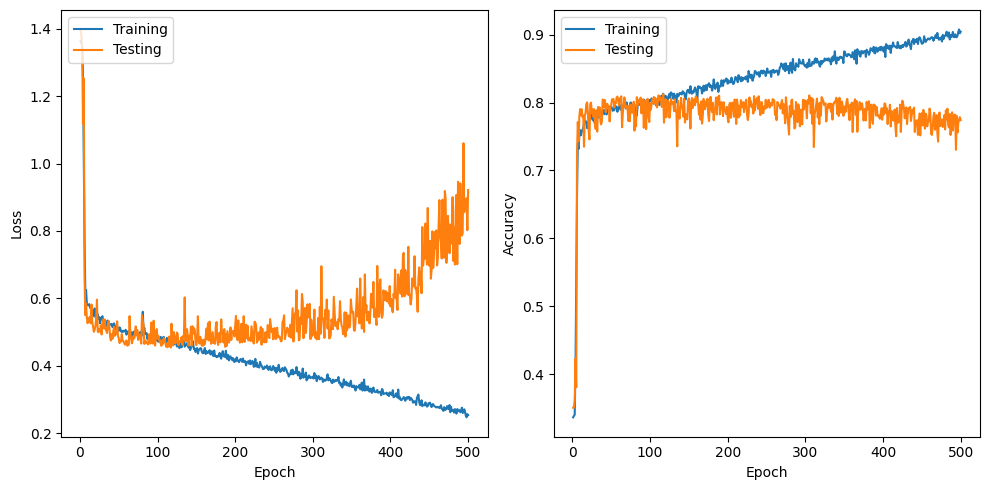

In [16]:
showTrainingLog(logs, epochs)

In [ ]:
showTrainingLog(logs, epochs, trained_epoch+1)

In [8]:
def calcCMScores(labels, preds, classes): # Confusion Matrix Scores
    total_TP = 0
    scores = []

    cm = confusion_matrix(y_true=labels, y_pred=preds, labels=list(range(classes)))
    cls_num = cm.shape[0]
    all_num = np.sum(cm)

    for i in range(cls_num):
        TP = cm[i, i]
        FP = np.sum(cm[:, i])-TP
        FN = np.sum(cm[i, :])-TP
        TN = all_num-FN-FP-TP
        
        spe = TN/(TN+FP) if TN != 0 else 0 # specificity
        sen = TP/(TP+FN) if TP != 0 else 0 # sensitivity
        pre = TP/(TP+FP) if TP != 0 else 0 # precision
        F1 = 2*(sen*pre)/(sen+pre) if pre+sen != 0 else 0 # F1-score
        scores.append([spe, sen, pre, F1])
        total_TP += TP
    acc = total_TP/all_num # accuracy
    
    return cm, acc, scores

In [19]:
def startEvaluation():
    model.eval()
    results = {}
    
    for p, phase in enumerate(['train', 'test1', 'test2', 'test3', 'test4']):
        data_num, running_acc = 0, 0.
        all_labels, all_preds = [], []

        if p == 0:
            batch_data = train_data
        elif p == 1:
            batch_data = test_data['shhs1']
        elif p == 2:
            batch_data = test_data['shhs2']
        elif p == 3:
            batch_data = test_data['apnea_ecg']
        elif p == 4:
            batch_data = test_data['耕莘dataset']

        pbar = tqdm(batch_data, unit='batch', desc=f'{phase:>5}: ')
        for b, batch in enumerate(pbar):
            signals, labels = batch

            with torch.no_grad():
                outputs = model(signals)
                _, preds = torch.max(outputs, 1)
            
            all_labels += labels.tolist()
            all_preds += preds.tolist()
        results[phase] = {'labels': all_labels, 'preds': all_preds}

    return results

def showResults(results, classes=4):
    for fname, result in results.items():
        metrics = []
        print(f'{fname}:')
        
        for k, v in result.items():
            labels, preds = v['labels'], v['preds']

            _, Acc, _ = calcCMScores(labels, preds, classes)
            metrics.append(Acc)
            
        df = pd.DataFrame(metrics, index=result.keys(), columns=['Acc'])
        display(df.round(4))

In [9]:
def getRecordType(type_):
    if type_ == 'fixed_len':
        record_type = 'Fixed Length'
    elif type_ == 'fixed_len-2c-5':
        record_type = 'Fixed Length (2-class, AHI>=5)'
    elif type_ == 'fixed_len-2c-15':
        record_type = 'Fixed Length (2-class, AHI>=15)'
    elif type_ == 'original_len':
        record_type = 'Original Length'
    elif type_ == 'original_len-2c-5':
        record_type = 'Original Length (2-class, AHI>=5)'
    elif type_ == 'original_len-2c-15':
        record_type = 'Original Length (2-class, AHI>=15)'
        
    return record_type

def getRecordPhase(phase):
    if phase == 'train':
        record_phase = 'Training (MESA, MrOS)'
    elif phase == 'test1':
        record_phase = 'Testing (SHHS1)'
    elif phase == 'test2':
        record_phase = 'Testing (SHHS2)'
    elif phase == 'test3':
        record_phase = 'Testing (Apnea-ECG)'
    elif phase == 'test4':
        record_phase = 'Testing (耕莘dataset)'
    print(f'{record_phase}:')
    
    return record_phase

def showConfusionMatrix(result_type, result, classes=4):
    writer = SummaryWriter(logs_tb_dir, filename_suffix=f'-CM_{result_type}.tb')
    record_type = getRecordType(result_type)
    fontsize = 14
    plt.rc('font', family='Times New Roman', size=fontsize)
    
    for k, v in result.items():
        record_phase = getRecordPhase(k)
        fig = plt.figure(figsize=(5, 5))
        
        labels, preds = v['labels'], v['preds']
        cm, acc, scores = calcCMScores(labels, preds, classes)
        print(f'Accuracy: {acc:.4f}')
        
        df = pd.DataFrame(scores, index=range(classes), columns=['Spe', 'Sen', 'Pre', 'F1'])
        df.loc['Mean'] = df.mean(axis=0)
        display(df.round(4))

        new_cm = np.array([(r/sum(r)*100) if sum(r) != 0 else np.zeros(classes) for r in cm])
        new_cm = [[f'{c1}\n({c2:.2f}%)' for c1, c2 in zip(r1, r2)] for r1, r2 in zip(cm, new_cm)]
        ax = sn.heatmap(cm, annot=new_cm, annot_kws={'size': fontsize}, cmap='Blues', cbar=False, fmt='',
                        linewidths=.5, linecolor='black', clip_on=False)

        ax.set_xlabel('Predicted', fontweight='bold', fontsize=fontsize)
        ax.set_ylabel('Labeled', fontweight='bold', fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
        plt.tight_layout()
        plt.show()
        writer.add_figure(f'Confusion Matrix ({record_type})/{record_phase}', fig)
    writer.close()

In [12]:
class EvaluationDataset(Dataset):
    def __init__(self, data_type, signal, label):
        self.data_type = data_type
        self.signal = signal
        self.label = label
        
    def __getitem__(self, index):
        if self.data_type == 'fixed': # fixed length
            signal = torch.tensor(cut_pad_signal(self.signal[index]), dtype=torch.float32).cuda().unsqueeze(0)
        elif self.data_type == 'original': # original length
            signal = torch.tensor(self.signal[index], dtype=torch.float32).cuda().unsqueeze(0)
        label = torch.tensor(self.label[index], dtype=torch.int64).cuda()
        return signal, label
    
    def __len__(self):
        return len(self.signal)

In [13]:
# fixed length results
batch_size = 128
train_data = DataLoader(EvaluationDataset('fixed', train_info['signal'], train_info['label']),
                        batch_size=batch_size)
test_data = {}
for k in test_list.keys():
    test_data[k] = DataLoader(EvaluationDataset('fixed', test_info[k]['signal'], test_info[k]['label']),
                              batch_size=batch_size)

In [14]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname] = startEvaluation()
    
with open(results_dir/'fixed_length.json', 'w') as f:
     json.dump(results, f)

best_acc:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.55batch/s]


best_loss:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.46batch/s]


epoch_100:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.09batch/s]


epoch_200:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.06batch/s]


epoch_300:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.46batch/s]


epoch_400:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.19batch/s]


epoch_500:


test4: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.46batch/s]


In [16]:
# for reload results
with open(results_dir/'fixed_length.json', 'r') as f:
     results = json.load(f)

In [20]:
showResults(results)

best_acc:


,Acc
train,0.8128
test1,0.8125
test2,0.7937
test3,0.8750
test4,0.8290


best_loss:


,Acc
train,0.8128
test1,0.8125
test2,0.7937
test3,0.8750
test4,0.8290


epoch_100:


,Acc
train,0.7974
test1,0.7989
test2,0.7620
test3,0.8750
test4,0.8319


epoch_200:


,Acc
train,0.8355
test1,0.7777
test2,0.7944
test3,0.8750
test4,0.7884


epoch_300:


,Acc
train,0.8632
test1,0.8029
test2,0.7812
test3,0.8750
test4,0.8174


epoch_400:


,Acc
train,0.8649
test1,0.7915
test2,0.7710
test3,0.8750
test4,0.8174


epoch_500:


,Acc
train,0.9053
test1,0.7740
test2,0.7827
test3,1.0000
test4,0.7884


In [11]:
# choose best result
chosen_result = results['best_acc']

Training (MESA, MrOS):
Accuracy: 0.8128


,Spe,Sen,Pre,F1
0,0.9701,0.7888,0.8517,0.8190
1,0.8979,0.8130,0.8035,0.8082
2,0.9140,0.7652,0.7633,0.7643
3,0.9591,0.8910,0.8571,0.8737
Mean,0.9353,0.8145,0.8189,0.8163


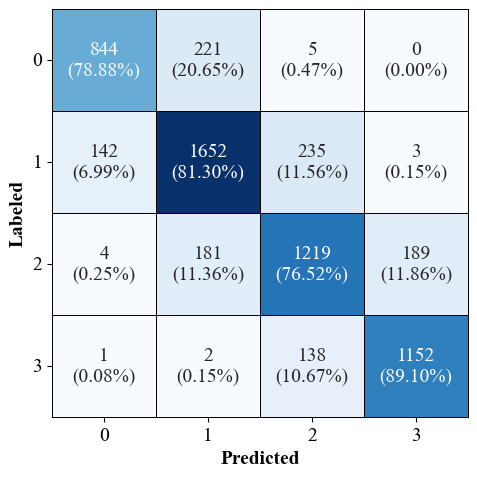

Testing (SHHS1):
Accuracy: 0.8125


,Spe,Sen,Pre,F1
0,0.9471,0.8511,0.8759,0.8633
1,0.8650,0.8223,0.7668,0.7935
2,0.9346,0.7478,0.7563,0.7520
3,0.9867,0.8024,0.9009,0.8488
Mean,0.9333,0.8059,0.8250,0.8144


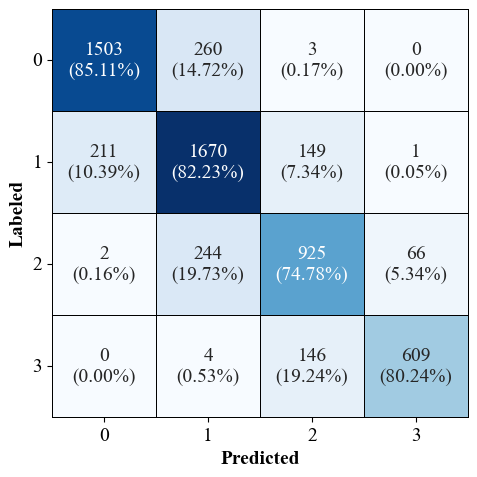

Testing (SHHS2):
Accuracy: 0.7937


,Spe,Sen,Pre,F1
0,0.9738,0.7504,0.8990,0.8180
1,0.8480,0.8167,0.7531,0.7836
2,0.9141,0.7504,0.7343,0.7422
3,0.9712,0.8706,0.8525,0.8615
Mean,0.9268,0.7970,0.8097,0.8013


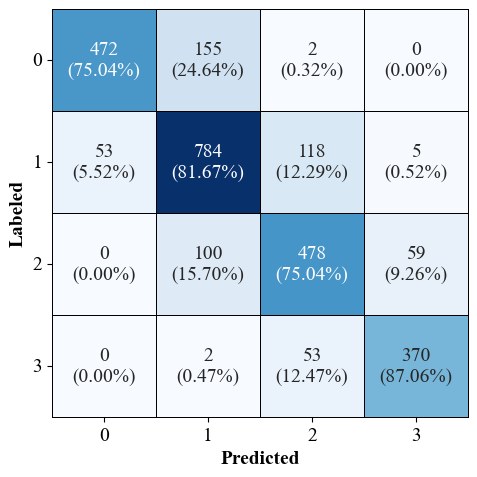

Testing (Apnea-ECG):
Accuracy: 0.8750


,Spe,Sen,Pre,F1
0,1.0000,0.7500,1.0,0.8571
1,0.8750,0.0000,0.0,0.0000
2,1.0000,0.0000,0.0,0.0000
3,1.0000,1.0000,1.0,1.0000
Mean,0.9688,0.4375,0.5,0.4643


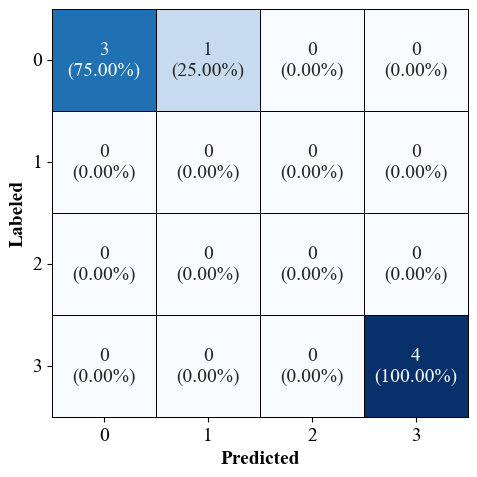

Testing (耕莘dataset):
Accuracy: 0.8290


,Spe,Sen,Pre,F1
0,0.9633,0.9111,0.7885,0.8454
1,0.9142,0.8442,0.7386,0.7879
2,0.9331,0.6230,0.6667,0.6441
3,0.9672,0.8765,0.9595,0.9161
Mean,0.9445,0.8137,0.7883,0.7984


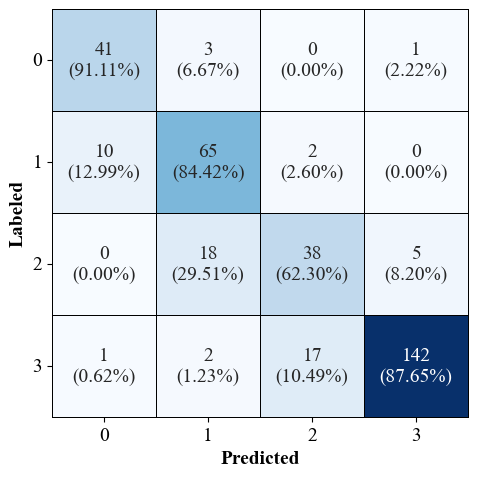

In [12]:
# Confusion Matrix
showConfusionMatrix('fixed_len', chosen_result)

Training (MESA, MrOS):
Accuracy: 0.9390


,Spe,Sen,Pre,F1
0,0.9707,0.7935,0.8550,0.8231
1,0.7935,0.9707,0.9558,0.9632
Mean,0.8821,0.8821,0.9054,0.8931


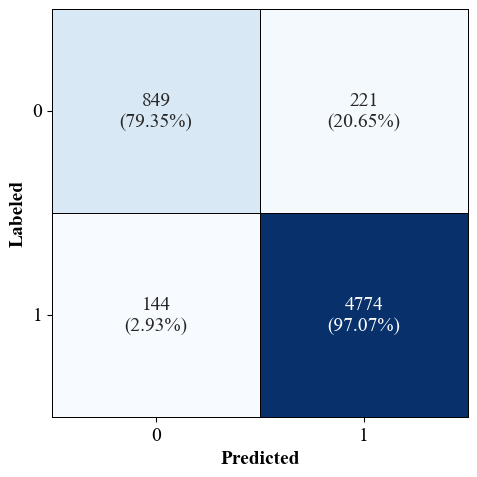

Testing (SHHS1):
Accuracy: 0.9163


,Spe,Sen,Pre,F1
0,0.9404,0.8613,0.8637,0.8625
1,0.8613,0.9404,0.9392,0.9398
Mean,0.9008,0.9008,0.9015,0.9012


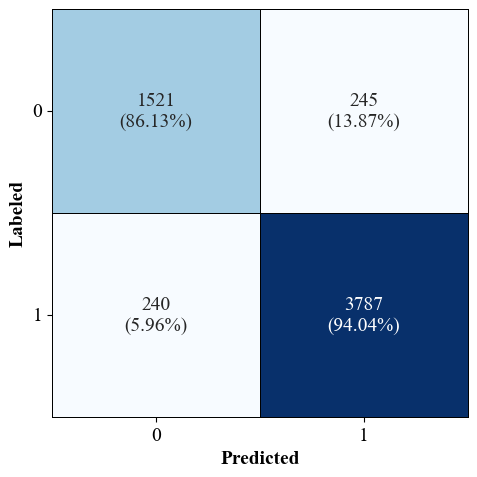

Testing (SHHS2):
Accuracy: 0.9215


,Spe,Sen,Pre,F1
0,0.9728,0.7568,0.8964,0.8207
1,0.7568,0.9728,0.9278,0.9498
Mean,0.8648,0.8648,0.9121,0.8852


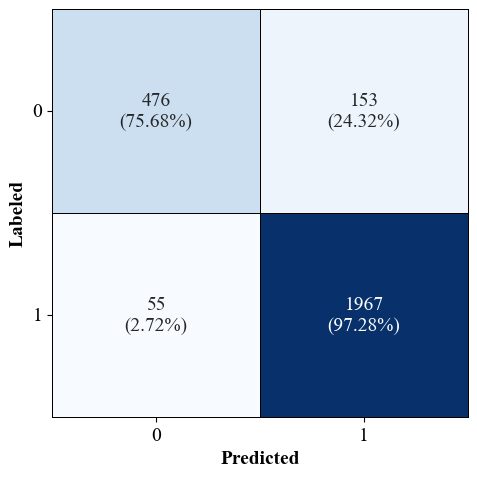

Testing (Apnea-ECG):
Accuracy: 0.8750


,Spe,Sen,Pre,F1
0,1.000,0.750,1.0,0.8571
1,0.750,1.000,0.8,0.8889
Mean,0.875,0.875,0.9,0.8730


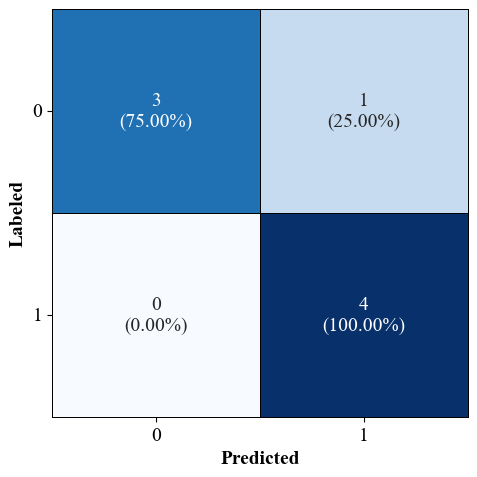

Testing (耕莘dataset):
Accuracy: 0.9507


,Spe,Sen,Pre,F1
0,0.9567,0.9111,0.7593,0.8283
1,0.9111,0.9567,0.9863,0.9712
Mean,0.9339,0.9339,0.8728,0.8998


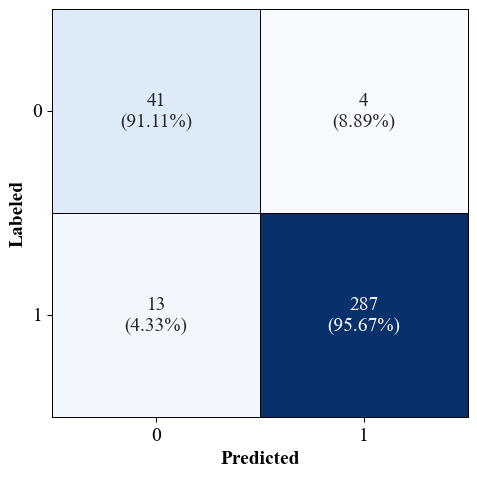

In [17]:
# Confusion Matrix (2-class, AHI>=5)
chosen_result_2c = {k: {} for k in chosen_result.keys()}
for k, v in chosen_result.items():
    for kk in ['labels', 'preds']:
        chosen_result_2c[k][kk] = [1 if vv >= 1 else 0 for vv in v[kk]]
showConfusionMatrix('fixed_len-2c-5', chosen_result_2c, 2)

Training (MESA, MrOS):
Accuracy: 0.9294


,Spe,Sen,Pre,F1
0,0.9425,0.9172,0.9449,0.9308
1,0.9172,0.9425,0.9137,0.9279
Mean,0.9298,0.9298,0.9293,0.9293


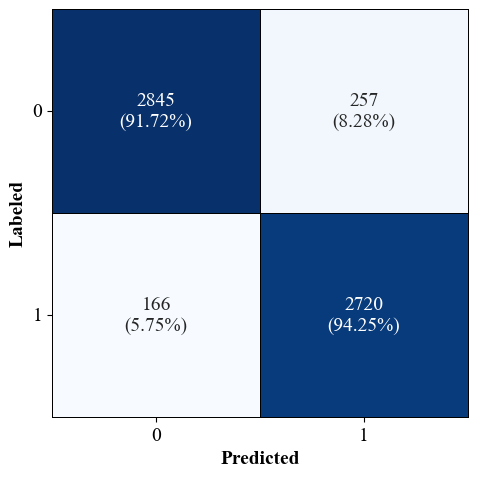

Testing (SHHS1):
Accuracy: 0.9275


,Spe,Sen,Pre,F1
0,0.8783,0.9534,0.9371,0.9452
1,0.9534,0.8783,0.9083,0.8930
Mean,0.9158,0.9158,0.9227,0.9191


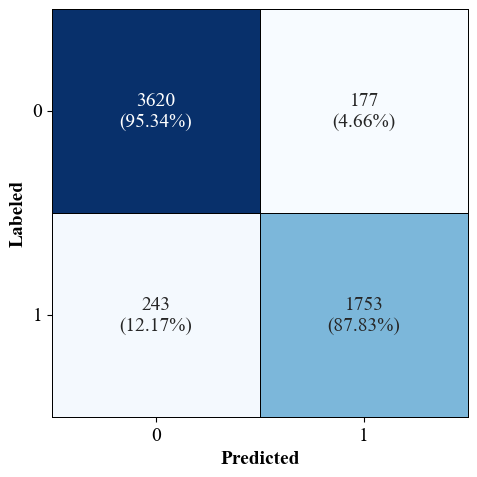

Testing (SHHS2):
Accuracy: 0.9125


,Spe,Sen,Pre,F1
0,0.9143,0.9113,0.9409,0.9258
1,0.9113,0.9143,0.8732,0.8933
Mean,0.9128,0.9128,0.9070,0.9096


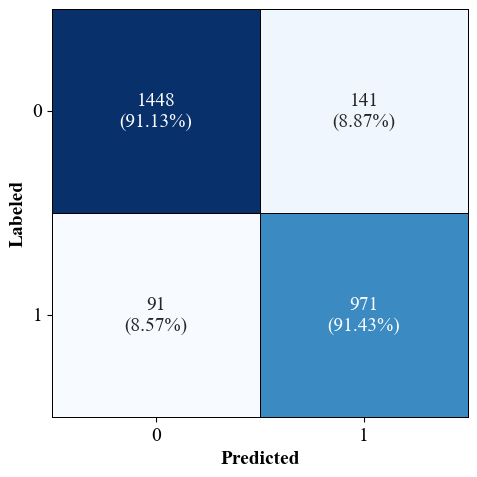

Testing (Apnea-ECG):
Accuracy: 1.0000


,Spe,Sen,Pre,F1
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
Mean,1.0,1.0,1.0,1.0


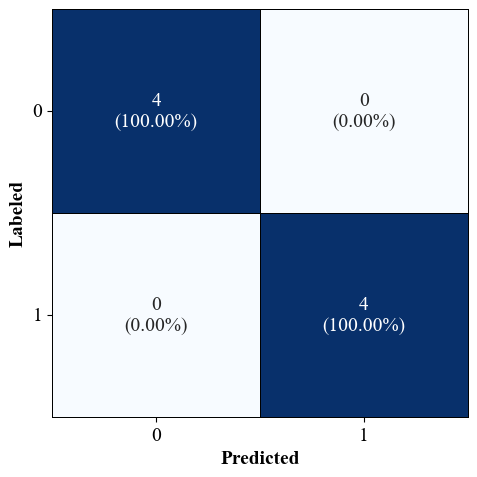

Testing (耕莘dataset):
Accuracy: 0.9275


,Spe,Sen,Pre,F1
0,0.9058,0.9672,0.8489,0.9042
1,0.9672,0.9058,0.9806,0.9417
Mean,0.9365,0.9365,0.9148,0.9230


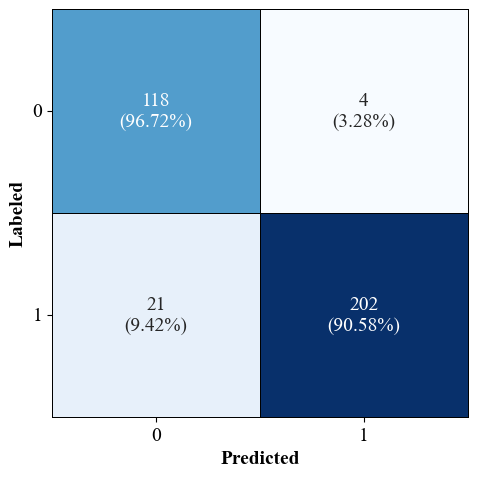

In [18]:
# Confusion Matrix (2-class, AHI>=15)
chosen_result_2c = {k: {} for k in chosen_result.keys()}
for k, v in chosen_result.items():
    for kk in ['labels', 'preds']:
        chosen_result_2c[k][kk] = [1 if vv >= 2 else 0 for vv in v[kk]]
showConfusionMatrix('fixed_len-2c-15', chosen_result_2c, 2)

In [20]:
# original length results
batch_size = 1
train_data = DataLoader(EvaluationDataset('original', train_info['signal'], train_info['label']),
                        batch_size=batch_size)
test_data = {}
for k in test_list.keys():
    test_data[k] = DataLoader(EvaluationDataset('original', test_info[k]['signal'], test_info[k]['label']),
                              batch_size=batch_size)

In [21]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname] = startEvaluation()

with open(results_dir/'original_length.json', 'w') as f:
     json.dump(results, f)

best_acc:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 142.83batch/s]


best_loss:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 145.16batch/s]


epoch_100:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 144.98batch/s]


epoch_200:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 150.93batch/s]


epoch_300:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 146.64batch/s]


epoch_400:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 140.62batch/s]


epoch_500:


test4: 100%|█████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 167.92batch/s]


In [13]:
# for reload results
with open(results_dir/'original_length.json', 'r') as f:
     results = json.load(f)

In [22]:
showResults(results)

best_acc:


,Acc
train,0.8176
test1,0.8075
test2,0.7944
test3,0.8750
test4,0.8174


best_loss:


,Acc
train,0.8176
test1,0.8075
test2,0.7944
test3,0.8750
test4,0.8174


epoch_100:


,Acc
train,0.8049
test1,0.7982
test2,0.7650
test3,0.8750
test4,0.8203


epoch_200:


,Acc
train,0.8429
test1,0.7811
test2,0.7922
test3,0.8750
test4,0.8058


epoch_300:


,Acc
train,0.8706
test1,0.7961
test2,0.7782
test3,0.8750
test4,0.8290


epoch_400:


,Acc
train,0.8619
test1,0.7847
test2,0.7605
test3,0.8750
test4,0.8261


epoch_500:


,Acc
train,0.8916
test1,0.7832
test2,0.7959
test3,1.0000
test4,0.8087


In [14]:
# choose best result
chosen_result = results['best_acc']

Training (MESA, MrOS):
Accuracy: 0.8176


,Spe,Sen,Pre,F1
0,0.9707,0.7935,0.8550,0.8231
1,0.9047,0.8076,0.8132,0.8104
2,0.9110,0.7884,0.7626,0.7753
3,0.9617,0.8894,0.8647,0.8769
Mean,0.9370,0.8197,0.8239,0.8214


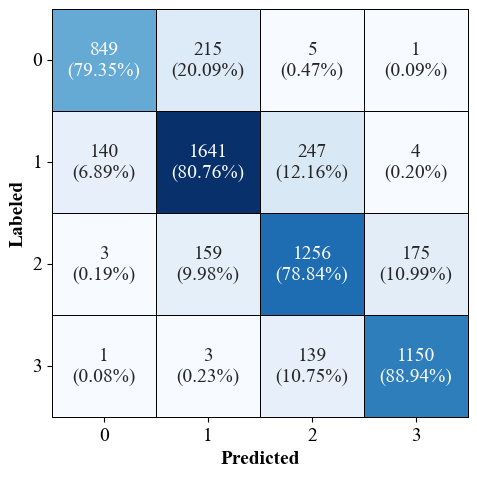

Testing (SHHS1):
Accuracy: 0.8075


,Spe,Sen,Pre,F1
0,0.9404,0.8613,0.8637,0.8625
1,0.8716,0.7971,0.7702,0.7835
2,0.9287,0.7526,0.7412,0.7469
3,0.9867,0.7997,0.9006,0.8472
Mean,0.9318,0.8027,0.8189,0.8100


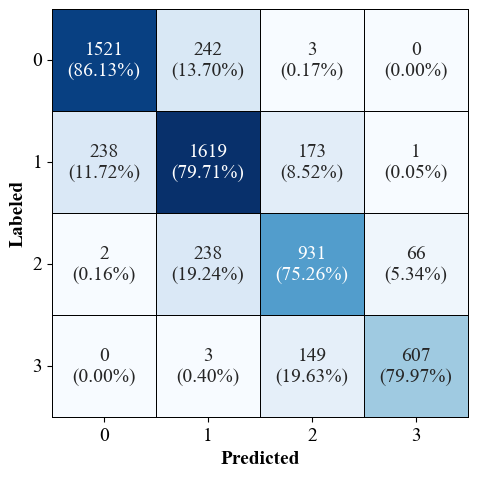

Testing (SHHS2):
Accuracy: 0.7944


,Spe,Sen,Pre,F1
0,0.9728,0.7568,0.8964,0.8207
1,0.8581,0.8000,0.7619,0.7805
2,0.9057,0.7739,0.7218,0.7470
3,0.9730,0.8682,0.8601,0.8642
Mean,0.9274,0.7997,0.8101,0.8031


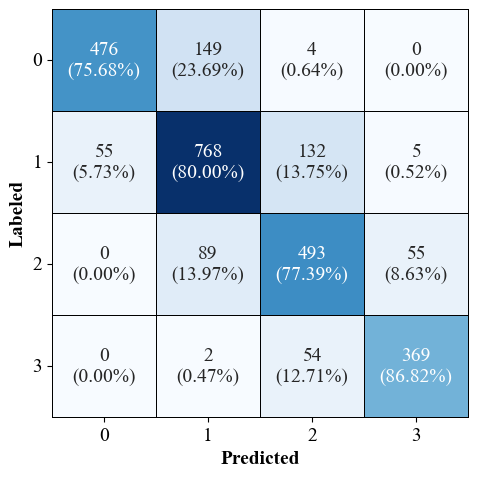

Testing (Apnea-ECG):
Accuracy: 0.8750


,Spe,Sen,Pre,F1
0,1.0000,0.7500,1.0,0.8571
1,0.8750,0.0000,0.0,0.0000
2,1.0000,0.0000,0.0,0.0000
3,1.0000,1.0000,1.0,1.0000
Mean,0.9688,0.4375,0.5,0.4643


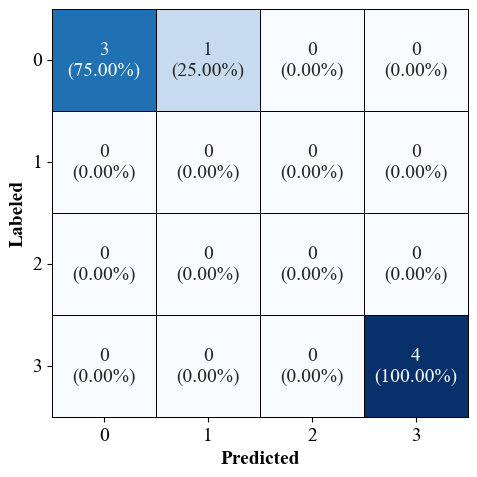

Testing (耕莘dataset):
Accuracy: 0.8174


,Spe,Sen,Pre,F1
0,0.9567,0.9111,0.7593,0.8283
1,0.9142,0.8052,0.7294,0.7654
2,0.9261,0.6230,0.6441,0.6333
3,0.9672,0.8704,0.9592,0.9126
Mean,0.9410,0.8024,0.7730,0.7849


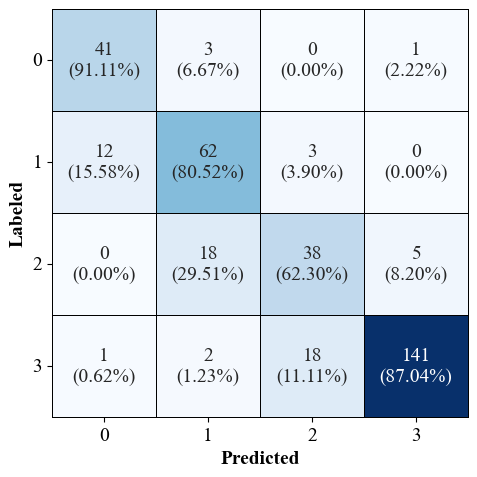

In [15]:
# Confusion Matrix
showConfusionMatrix('original_len', chosen_result)